In [1]:
import os
#import scipy
import numpy as np
import pandas as pd
#import netCDF4 as nc
import matplotlib.pyplot as plt
import sys
#import skimage
from functools import reduce


#from sklearn.cross_decomposition import PLSRegression, PLSCanonical, CCA
#from sklearn.decomposition import PCA

#from sklearn.cluster import FeatureAgglomeration
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import cross_validate, RepeatedKFold


sys.path.append('../functions/')
from functions import load_lat_lon_area, display_map, reverse_mask, nanaverage, nanstd, display_number_of_runs



In [2]:

#!!!!! qu'est ce qui est nécessaire ???

#from muchos_functions import compute_trend_3d_data, get_biggest_connected_component, construct_matrix_from_subgraph, assign_weight_to_cluster_variables, seuillage_correlation_matrix, display_map, fill_signal, smooth_data, reverse_mask, construct_connectivity_matrix_3d, construct_smooth_connectivity_matrix_3d

#from functions_causality import correlation_glissante, compute_ttest_pvalue
#from lagged_trend import compute_lagged_trend_per_model

#from method_C import compute_correlation_per_cellPattern, compute_weights_smooth_PLS, recover_cells_in_pattern_near_cell

#from load_tos_dos_sos_AMOC import load_multiple_var
#from temporal_metrics import compute_temporal_metrics

#from method_C_clustering import clustering_based_on_connectivity, compute_labels_given_n_clusters, construct_dictionnary_from_clustering, compute_correlation_per_region, select_N_most_correlated_components, method_C_k_components, method_C_k_components_multipleVar

#from load_tos_dos_sos_AMOC import load_tos_dos_sos_AMOC, load_data_given_metric

# !!!!!!!!!


# Choices of X and Y 

In [3]:
scenario   = "ssp245" # ssp126, ssp245 ou ssp585

#------- Y
anomalie_Y = False
min_Y      = 2091
max_Y      = 2100
min_Y_ref  = 1850
max_Y_ref  = 1900

#------- X
X_choice = "mean" # mean, trend
min_X    = 1900 # 1900 or 1975 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
max_X    = 2020

#------- X en multivarié : est ce qu'on inclue l'AMOC passé en plus des 18 features ?
include_AMOC_in_predictors=True

# Import data

In [4]:
from import_data import import_CMIP6_TOS_SOS, import_CMIP6_AMOC, select_common_members, import_AMOC_obs, import_TOS_SOS_obs, region_average_TOS_SOS_obs, display_regions

#---- Import labels longitudes and latitudes
latitudes, longitudes, area_perLat_per_Lon = load_lat_lon_area("../data/area_r360x180.nc")
longitudes[longitudes>180] -= 360

#---- Import CMIP6 TOS and SOS
years_to_select = np.arange(1850, 2100+1)
[X_simu_perSample_perYear_perFeature_bis, name_samples_X, nb_var, list_name_per_var
            ] = import_CMIP6_TOS_SOS(scenario, years_to_select)

#---- Import CMIP6 AMOC
[hist_times, hist_name_samples, hist_AMOC, ssp_times, ssp245_name_samples, ssp245_AMOC
        ] = import_CMIP6_AMOC(scenario)

#---- Select only the members that are available for both TOS, SOS and AMOC
[X_simu_perSample_perYear_perFeature, Y, times_Y, final_name_samples
        ] = select_common_members(name_samples_X, hist_name_samples, ssp245_name_samples,
                         X_simu_perSample_perYear_perFeature_bis,
                         years_to_select, hist_times, ssp_times,
                         hist_AMOC, ssp245_AMOC)

#---- Import AMOC observations (RAPID)
obs_AMOC_times, obs_AMOC_values = import_AMOC_obs(display=False)

#---- Import TOS and SOS observations
[ObsData_perVar_perYear_perCell_, ObsVar_perVar_perYear_perCell_,
 obs_times, mask_perVar
        ] = import_TOS_SOS_obs(years_to_select, display=False)

[X_obs_perYear_perFeature, X_obsVar_perYear_perFeature,
 name_perBox, list_idCell_perFeature, list_id_box_perFeature,
 list_id_var_perFeature, colors_perBox,
 middle_cell_perBox, list_name_perFeature, nb_box
        ] = region_average_TOS_SOS_obs(longitudes, latitudes,
                               ObsData_perVar_perYear_perCell_, ObsVar_perVar_perYear_perCell_,
                               area_perLat_per_Lon, list_name_per_var, obs_times, mask_perVar, display=False)

#---- Display the number of members given by each climate model
final_name_models, final_weight_per_sample = display_number_of_runs(final_name_samples, display=False)



C:\Users\vportmann\.conda\envs\test\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\vportmann\.conda\envs\test\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Figure S1: Display the regions

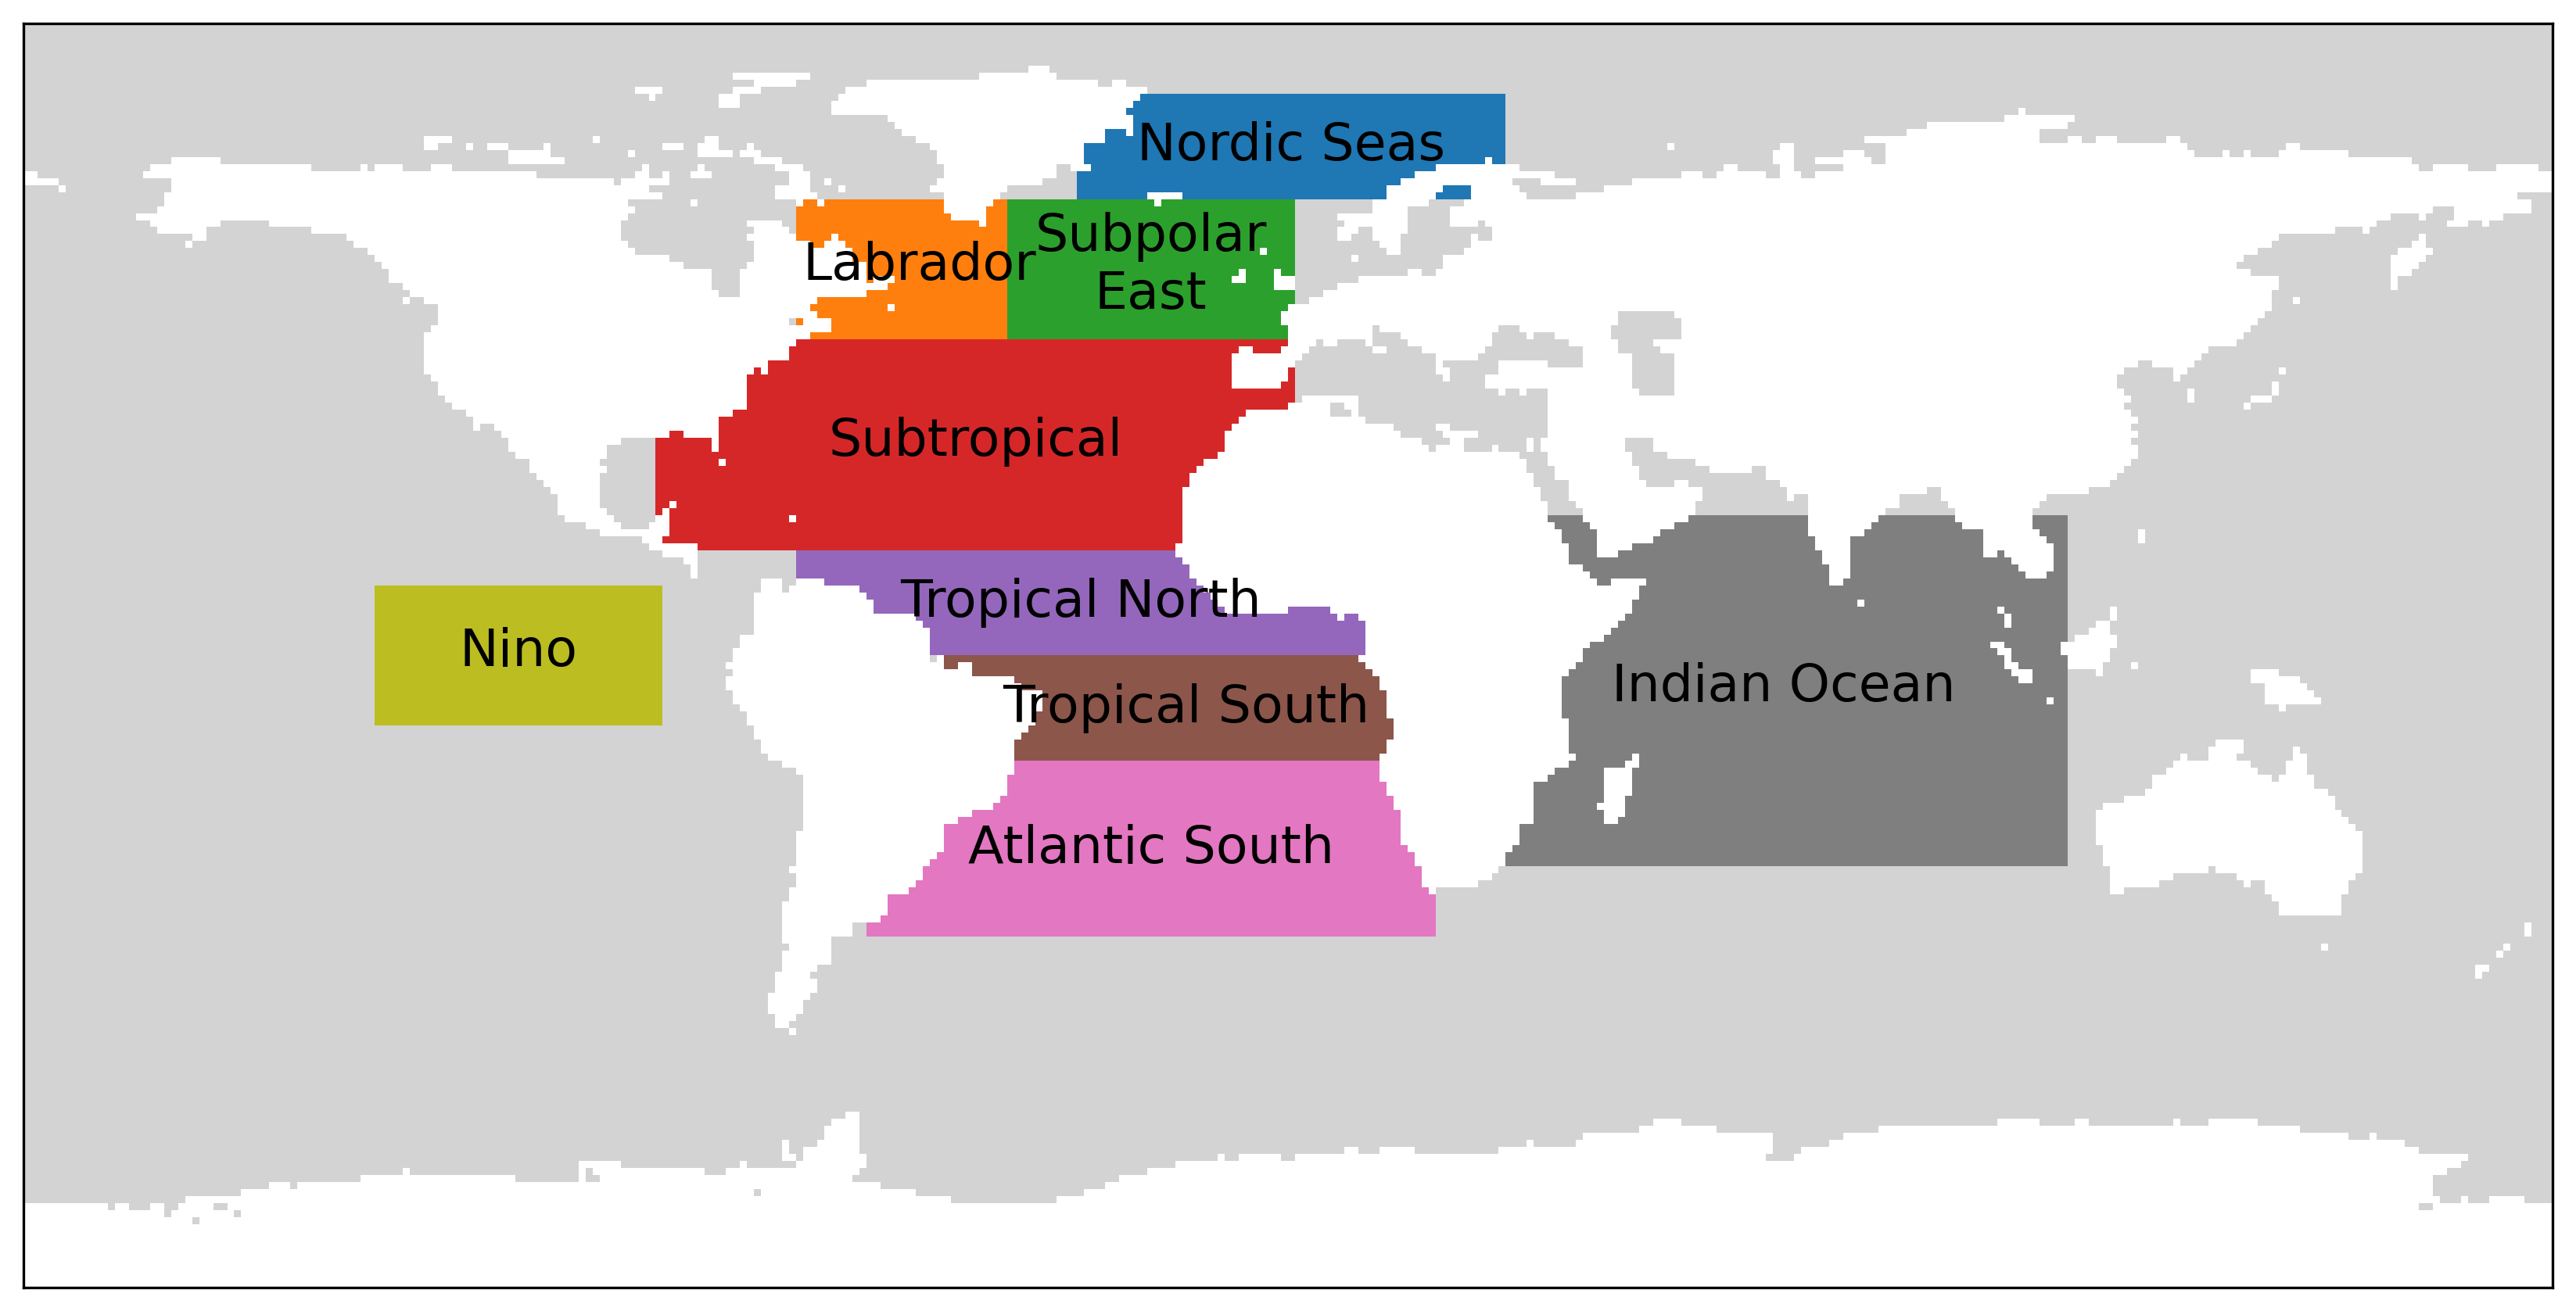

In [5]:
display_regions(
    mask_perVar, name_perBox, list_idCell_perFeature,
    list_id_box_perFeature, list_id_var_perFeature, colors_perBox,
    latitudes, longitudes, middle_cell_perBox)

# Format data into X and Y

In [6]:
from format_data import create_X_AMOC_feature, create_X_TOS_SOS_features, create_Y_AMOC_feature, average_member_perModel

#------- X definition for the AMOC
[name_X_AMOC, X_simu_AMOC, X_obs_AMOC, X_AMOC_mean_1850_1900
        ] = create_X_AMOC_feature(X_choice, Y, times_Y, obs_AMOC_values, obs_AMOC_times)
print("{} (RAPID) is {:.2f} Sv.".format(name_X_AMOC, X_obs_AMOC))

#------- X definition for the TOS and SOS
X_obs, X_simu = create_X_TOS_SOS_features(X_choice, min_X, max_X, 
                                          X_obs_perYear_perFeature, obs_times,
                                          X_simu_perSample_perYear_perFeature, years_to_select)

#------- Y definition for the AMOC
Y_simu, name_Y, Y_ref = create_Y_AMOC_feature(anomalie_Y, min_Y, max_Y,
                          min_Y_ref, max_Y_ref,
                          Y, years_to_select)

#------- Select only the run without nan values
model_to_keep     = np.logical_not(np.isnan(Y_simu))
Y_ref             = Y_ref[model_to_keep]
Y_simu            = Y_simu[model_to_keep]
X_simu            = X_simu[model_to_keep]
X_simu_AMOC       = X_simu_AMOC[model_to_keep]
final_name_samples = final_name_samples[model_to_keep]
final_name_models  = np.array(final_name_models)[model_to_keep]
X_AMOC_mean_1850_1900   = X_AMOC_mean_1850_1900[model_to_keep]

#------- Combine (or not) the X SST and SSS features with the X AMOC feature
if include_AMOC_in_predictors:
    X_simu = np.concatenate((X_simu, X_simu_AMOC.reshape(-1,1)), axis=1)
    X_obs  = np.concatenate((X_obs, X_obs_AMOC.reshape(-1)))
    list_name_perFeature.append(name_X_AMOC)
    list_id_var_perFeature.append(2)
    
#------- Average each model on its available members
[uniques_models, Y_simu_resampled, Y_ref_resampled, X_simu_resampled, X_simu_AMOC_resampled, X_AMOC_mean_1850_1900_resampled
        ] = average_member_perModel(final_name_models, X_simu, Y_simu,
                            Y_ref, X_simu_AMOC, X_AMOC_mean_1850_1900)
nb_models = len(uniques_models)

#------- Replacement
X_simu                = X_simu_resampled
Y_simu                = Y_simu_resampled
Y_ref                 = Y_ref_resampled
X_simu_AMOC           = X_simu_AMOC_resampled
X_AMOC_mean_1850_1900 = X_AMOC_mean_1850_1900_resampled
final_name_models     = np.copy(uniques_models)


mean AMOC 2005-2023 (RAPID) is 16.95 Sv.


C:\Users\vportmann\Desktop\ComparisonAmocConstraints\notebooks\../functions\format_data.py:99: RuntimeWarning: Mean of empty slice
  Y_simu_anom = np.nanmean(Y_anom[:, times_to_mean], axis=1)
C:\Users\vportmann\Desktop\ComparisonAmocConstraints\notebooks\../functions\format_data.py:106: RuntimeWarning: Mean of empty slice
  Y_simu = np.nanmean(Y[:, times_to_mean], axis=1)


# RMSE

In [ ]:
from OC_methods import performances_methods
[name_methods, list_list_predictions, list_list_std_without, list_list_LOO
        ] = performances_methods(X_simu_AMOC, X_obs_AMOC, X_simu, X_obs, Y_simu)

MMM

wAverage



In [ ]:
data = np.concatenate((np.array(name_methods).reshape(1,-1),
                       np.array(list_list_predictions[0]).reshape(1,-1).round(1),
                       np.array(list_list_std_without[0]).reshape(1,-1).round(1),
                       np.array(list_list_LOO[0]).reshape(1,-1).round(1)))

print("univariate")
pd.DataFrame(data, index=["Method", "Prediction", "Std", "LOO"])


In [ ]:
data = np.concatenate((np.array(name_methods).reshape(1,-1),
                       np.array(list_list_predictions[1]).reshape(1,-1).round(1),
                       np.array(list_list_std_without[1]).reshape(1,-1).round(1),
                       np.array(list_list_LOO[1]).reshape(1,-1).round(1)))

print("multivariate")
pd.DataFrame(data, index=["Method", "Prediction", "Std", "LOO"])

In [ ]:
from scipy.stats import t
conf = 0.90
z    = t.interval(conf, np.inf, loc=0, scale=1)[1]

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6,5), dpi=300)
nb_methods = len(name_methods)

alpha = 0.6
beta = 0.1
x = 0.1

if scenario=='ssp245':
    ymin = 4
    ymax = 20.5
    if X_choice== "trend":
        ymax=20
elif scenario=='ssp585':
    ymin = 4
    ymax = 20.5+3
elif scenario=='ssp126':
    ymin = 4
    ymax = 20.5+3
    


#------------ Analytique
colors = prop_cycle.by_key()['color']
for id_method in range(nb_methods):
    for i in range(2):
        if id_method==0: shift = 0
        else: shift = beta*(2*i-1)
        std_without = list_list_std_without[i][id_method]
        pred        = list_list_predictions[i][id_method]
        y1=ymin*np.ones(2)
        y2=(pred)*np.ones(2)
        
        if anomalie_Y:
            ymin=-12
            ymax=0
            y2=0*np.ones(2)
            y1=(pred)*np.ones(2)
    
        if i==0:
            linestyle="solid"
            marker="x"
            axes[0].fill_between(id_method+shift+np.array([-x,x]), y1=y1, y2=y2,
                             color=colors[id_method], alpha=alpha)
        else:
            linestyle="dashed"
            marker="o"
            axes[0].fill_between(id_method+shift+np.array([-x,x]), y1=y1, y2=y2,
                             color="none", hatch="XXX", edgecolor=colors[id_method])
            
        axes[0].errorbar(id_method+shift, pred, yerr=z*std_without, capsize=7, color="black", lw=2, alpha=0.8, fmt="_")
        
        if id_method==3 and i==1:
            axes[0].fill_between(id_method+shift+np.array([-x,x]), y1=y1, y2=y2,
                             facecolors='none', edgecolors='black', linewidth=1)
                


axes[0].set_ylim(ymin, ymax)

std  = list_list_std_without[0][0]
pred = list_list_predictions[0][0]
line1 = axes[0].fill_between(id_method+np.array([-x,x])+10, y1=(pred-std)*np.ones(2), y2=(pred+std)**np.ones(2),
                             color="gray", alpha=alpha, label="one predictor")
line2 = axes[0].fill_between(id_method+np.array([-x,x])+10, y1=(pred-std)*np.ones(2), y2=(pred+std)**np.ones(2),
                             color="none", hatch="XXX", edgecolor="gray", label="multiple predictor")
line3 = axes[0].errorbar(id_method+shift+10, pred, yerr=z*std, capsize=7, color="black", lw=2, alpha=0.8, fmt="_")



#axes[0].errorbar(id_method+10, list_predictions, yerr=list_std, capsize=7, color=colors[id_method],
#                         label="one predictor", fmt='o')
axes[0].set_xlim(-0.5, nb_methods-0.5)

#------------ Empirique (validation croisée)
xmin = 0
for id_method in range(nb_methods):
    for i in range(2):
        if id_method==0: shift = 0
        else: shift = beta*(2*i-1)
        LOO_err = list_list_LOO[i][id_method]
        
        if i==0:
            linestyle="solid"
            axes[1].fill_between(id_method+shift+np.array([-x,x]), y1=[xmin,xmin], y2=LOO_err*np.array([1,1]), color=colors[id_method], alpha=alpha)
        else:
            linestyle="dashed"
            axes[1].fill_between(id_method+shift+np.array([-x,x]), y1=[xmin,xmin], y2=LOO_err*np.array([1,1]),
                                 color="none", hatch="XXX", edgecolor=colors[id_method])
        if id_method==3 and i==1:
            axes[1].fill_between(id_method+shift+np.array([-x,x]), y1=xmin*np.ones(2), y2=(LOO_err)*np.ones(2),
                             facecolors='none', edgecolors='black', linewidth=1)
            
            
        #axes[1].fill_between(id_method+shift+np.array([-x,x]), y1=[xmin,xmin], y2=LOO*np.array([1,1]), color=colors[id_method])
        
axes[0].set_ylabel(name_Y+" (Sv)")
axes[1].set_ylabel("Cross validation error")
axes[1].set_xticks(range(nb_methods))
axes[1].set_xticklabels(name_methods)
axes[0].grid(axis="y")
axes[1].grid(axis="y")
axes[0].set_title("A. Constrained projections")
axes[1].set_title("B. Cross-validation performances")
plt.rc('axes', axisbelow=True)
#axes[0].legend(title="Constrained by")
leg = fig.legend([line1, line2, line3],
           ["one observed variable", "multiple observed variables", r"$\pm$"+" 90% uncertainty"], #"1 "+r"$\sigma$"+" interval"],
           title="Constrained by", loc='center left', bbox_to_anchor=(0.9, 0.5))
leg._legend_box.align = "left"
#fig.suptitle("Comparison of method results")
axes[1].get_xticklabels()[3].set_fontweight("bold")
axes[1].set_ylim(0)
plt.show()

# Représentation univarié RL et wAverage

In [ ]:
# Probability
from scipy.stats import t
conf = 0.90
z    = t.interval(conf, np.inf, loc=0, scale=1)[1]
print(z)

# Values
std_err_LR  = z*list_list_std_without[0][2]
std_err_wA  = z*list_list_std_without[0][1]
weights     = poids_wA[0]
uni_lr_pred = list_list_predictions[0][2]
uni_wA_pred = list_list_predictions[0][1]

uni_wA_pred, std_err_wA

In [ ]:
def define_color_and_marker(common_models, list_front_markers, list_back_markers,
                            based_on_institute=True, other_names=[], other_models=[]):
    
    
    # Couleurs
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    # Instituts
    if based_on_institute:
        name_models    = np.load("../data/historical_AMOC/name_model_per_model.npy")
        name_institute = np.load("../data/historical_AMOC/name_institute_per_model.npy")
        
    else:
        name_models    = other_models
        name_institute = other_names
        
    _, indexes_to_keep, new_indexes = np.intersect1d(name_models, common_models, return_indices=True)
    institute_per_model   = name_institute[indexes_to_keep]
    institute_per_model[np.where(institute_per_model=='DKRZ')] = 'MPI-M'
    nb_models = len(common_models[new_indexes])

    unique_institute_per_model = []
    for institute in institute_per_model:
        if not (institute in unique_institute_per_model):
            unique_institute_per_model.append(institute)
    unique_institute_per_model = np.array(unique_institute_per_model)

    # 
    k = 0
    k_per_institute   = np.zeros(len(unique_institute_per_model), dtype=int)
    list_color        = []
    list_front_marker = []
    list_back_marker  = []
    for id_model in range(nb_models):
        institute    = institute_per_model[id_model]
        id_institute = np.where(unique_institute_per_model==institute)[0][0]
        color        = colors[id_institute%len(colors)]
        depassement  = id_institute//len(colors)        
        front_marker = list_front_markers[k_per_institute[id_institute]]
        back_marker  = list_back_markers[depassement]
        
        list_color.append(color)
        list_front_marker.append(front_marker)
        list_back_marker.append(back_marker)
        k_per_institute[id_institute] += 1
        
        
    #original_indexes                  = np.zeros(len(indexes_to_keep), dtype=int)
    #original_indexes[indexes_to_keep] = np.arange(len(indexes_to_keep))
    
    #list_color        = np.array(list_color)[original_indexes]
    #list_front_marker = np.array(list_front_marker)[original_indexes]
    #list_back_marker  = np.array(list_back_marker)[original_indexes]

    return list_color, list_front_marker, list_back_marker

In [ ]:
alpha = 0.9
option = 1 #1 ou 2
xmargin = 0.5

from sklearn.linear_model import LinearRegression

if option==1:
    fig = plt.figure(figsize=(12*alpha,4*alpha))
else:
    fig = plt.figure(figsize=(6*alpha, 8*alpha))
    
#AMOC_data_mask, AMOC_data_name_models, AMOC_data_times, AMOC_data = load_data_given_metric(
#    "AMOC", work_in_anomaly=False, on_reshaped_data=False, period="ssp245")

    
#------------- Affichage des incertitudes sur X_obs et X_simu
if option==1: plt.subplot(121)
else: plt.subplot(211)
plt.rc('hatch', color='green', linewidth=0.1)
plt.axvline(X_obs_AMOC, color='green', alpha=0.5, label='real-world observation', linewidth=2)
#line1 = plt.fill_betweenx([np.min(Y_simu), np.max(Y_simu)], X_obs_AMOC-X_obs_AMOC_std, X_obs_AMOC+X_obs_AMOC_std,
#                  alpha=0., hatch=r"\\", label='observation $\pm \sigma$')
plt.rc('hatch', color='red', linewidth=0.25)
if False:
    plt.axvline(np.mean(X_simu_AMOC), color='red', alpha=0.5)
    line2 = plt.fill_betweenx([np.min(Y_simu), np.max(Y_simu)], np.mean(X_simu_AMOC)-np.std(X_simu_AMOC),
                  np.mean(X_simu_AMOC)+np.std(X_simu_AMOC),
                  alpha=0., hatch="//", label='multi-model mean $\pm \sigma$', linewidth=12)
#line3 = plt.axhline(y=uni_wA_pred, linestyle='dotted', color='black',
#                   label="prediction ({} Sv)".format(np.round(ypred_obs, 1)))
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
plt.errorbar(xmin+xmargin, uni_wA_pred, yerr=std_err_wA, capsize=7, color="black", lw=2, alpha=0.8, fmt="_",
             label="{:.1f} ".format(uni_wA_pred)+r"$\pm$"+" {:.1f} Sv".format(std_err_wA)) # r"$\hat{f}(x_0)\pm \hat{\sigma}_{\varepsilon}$")
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#legend1 = plt.legend(handles=[line1, line3]) #line2
legend1 = plt.legend()
plt.ylabel(name_Y+" (Sv)")
plt.xlabel(name_X_AMOC+" (Sv)")
plt.title("A. Weighted average")






#------------- Affichage des modèles
list_front_markers = ["<", ">", "^", "v", "o", "s", "p", "*", "h", "H", "d", "P", "X"] #, "+", "x", "*", "o"
list_back_markers  = ["o", "s", "d"]


#common_models, id_common_AMOC_models, _ = np.intersect1d(
#        AMOC_data_name_models, final_name_models, return_indices=True)
list_color, list_front_marker, list_back_marker = define_color_and_marker(final_name_models, list_front_markers, list_back_markers)
#list_color, list_front_marker, list_back_marker = np.array(list_color)[id_common_AMOC_models], np.array(list_front_marker)[id_common_AMOC_models], np.array(list_back_marker)[id_common_AMOC_models]


list_points = []
for id_model in range(len(final_name_models)):
    front_marker = list_front_marker[id_model]
    back_marker  = list_back_marker[id_model]
    color        = list_color[id_model]
    alpha        = 0.5
    a, = plt.plot(X_simu_AMOC[id_model], Y_simu[id_model], marker=back_marker, c=color, alpha=alpha, markersize=10, linewidth=0.)
    b, = plt.plot(X_simu_AMOC[id_model], Y_simu[id_model], marker=front_marker, label=final_name_models[id_model], c=color, alpha=1, linewidth=0.)
    list_points.append((a,b))

#legend2 = plt.legend(list_points, common_models, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

plt.gca().add_artist(legend1)

plt.scatter(X_simu_AMOC, Y_simu, facecolors='none', s=300, edgecolors='black', linewidth=10*weights)








if option==1: plt.subplot(122)
else: plt.subplot(212)
#------------- Affichage de la régression
lr        = LinearRegression().fit(X_simu_AMOC.reshape(-1, 1), Y_simu)
ypred     = lr.predict(X_simu_AMOC.reshape(-1, 1))
ypred_obs = lr.predict(X_obs_AMOC.reshape(-1, 1))[0]
x         = np.linspace(X_simu_AMOC.min(), X_simu_AMOC.max())
y         = lr.predict(x.reshape(-1, 1))

plt.axvline(X_obs_AMOC, color='green', alpha=0.5, label="real-world observation", linewidth=2)
plt.rc('hatch', color='green', linewidth=0.25)
#line1 = plt.fill_betweenx([np.min(Y_simu), np.max(Y_simu)], X_obs_AMOC-X_obs_AMOC_std, X_obs_AMOC+X_obs_AMOC_std,
#                  alpha=0., hatch=r"\\", label='observation $\pm \sigma$')
line2 = plt.plot(X_simu_AMOC, ypred, color='red')#, label='linear regression')
plt.fill_between(x, y-std_err_LR, y+std_err_LR, color='red', alpha=0.2)

xmin, xmax = plt.gca().get_xlim()
plt.errorbar(xmin+xmargin, uni_lr_pred, yerr=std_err_LR, capsize=7, color="black", lw=2, alpha=0.8, fmt="_",
             label="{:.1f} ".format(uni_lr_pred)+r"$\pm$"+" {:.1f} Sv".format(std_err_LR)) # r"$\hat{f}(x_0)\pm \hat{\sigma}_{\varepsilon}$")


#line3 = plt.axhline(y=uni_lr_pred, xmin=0, xmax=(X_obs_AMOC-xmin)/(xmax-xmin), linestyle='dotted', color='black',
#                   label="prediction ({} Sv)".format(np.round(ypred_obs, 1)))

legend1 = plt.legend()#handles=[line1, line3])
plt.hlines(y=uni_lr_pred, xmin=xmin+xmargin, xmax=X_obs_AMOC, linestyle="dotted", color='black', linewidth=1)
plt.hlines(y=uni_lr_pred-std_err_LR, xmin=xmin+xmargin, xmax=X_obs_AMOC, linestyle="dotted", color='black')
plt.hlines(y=uni_lr_pred+std_err_LR, xmin=xmin+xmargin, xmax=X_obs_AMOC, linestyle="dotted", color='black')




#------------- Affichage des modèles
list_front_markers = ["<", ">", "^", "v", "o", "s", "p", "*", "h", "H", "d", "P", "X"] #, "+", "x", "*", "o"
list_back_markers  = ["o", "s", "d"]

#common_models, id_common_AMOC_models, _ = np.intersect1d(
#        AMOC_data_name_models, final_name_models, return_indices=True)
list_color, list_front_marker, list_back_marker = define_color_and_marker(final_name_models, list_front_markers, list_back_markers)
#list_color, list_front_marker, list_back_marker = np.array(list_color)[id_common_AMOC_models], np.array(list_front_marker)[id_common_AMOC_models], np.array(list_back_marker)[id_common_AMOC_models]


list_points = []
for id_model in range(len(final_name_models)):
    front_marker = list_front_marker[id_model]
    back_marker  = list_back_marker[id_model]
    color        = list_color[id_model]
    alpha        = 0.5
    a, = plt.plot(X_simu_AMOC[id_model], Y_simu[id_model], marker=back_marker, c=color, alpha=alpha, markersize=10, linewidth=0.)
    b, = plt.plot(X_simu_AMOC[id_model], Y_simu[id_model], marker=front_marker, label=final_name_models[id_model], c=color, alpha=1, linewidth=0.)
    list_points.append((a,b))

if True:
    if option==1:
        fig.legend(list_points, final_name_models, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=6)
    else:
        fig.legend(list_points, final_name_models, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
else:
    fig.legend(list_points, final_name_models, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

#legend2 = plt.legend(list_points, final_name_models, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.ylabel(name_Y+" (Sv)")
plt.xlabel(name_X_AMOC+" (Sv)")
plt.title("B. Linear regression")


#plt.gca().add_artist(legend1)
plt.tight_layout()
plt.show()


# Représentation des poids de RL-Ridge

In [ ]:
scaler = StandardScaler()
X_simu_n = scaler.fit_transform(X_simu)
X_obs_n = scaler.transform(X_obs.reshape(1,-1))
model = model_RidgeCV_noisy(Cov_obs=Cov_obs).fit(X_simu_n, Y_simu)
Beta = model.model.coef_
intercept = model.model.intercept_


#----------------------------------------------------------------------------------
pd.set_option("display.precision", 2)

data = np.concatenate((Beta.reshape(-1,1),
                       (X_obs_n-np.mean(X_simu_n, axis=0)).reshape(-1,1),
                       (Beta*(X_obs_n-np.mean(X_simu_n, axis=0))).reshape(-1,1)), axis=1)

In [ ]:
name_region_per_feature = np.array([elt.split('os ')[1] for elt in list_name_perFeature[:-1]])
name_feature_AMOC = list_name_perFeature[-1]

unique_name_regions = np.unique(name_region_per_feature)

list_name_feature_bis = []
data_bis = np.zeros((len(unique_name_regions)+1, data.shape[1]))
id_feature_bis = 0
for name_region in unique_name_regions:
    id_tos_region = np.argwhere('tos '+name_region==np.array(list_name_perFeature))[0][0]
    id_sos_region = np.argwhere('sos '+name_region==np.array(list_name_perFeature))[0][0]
    
    data_bis[id_feature_bis, :] = data[id_tos_region] + data[id_sos_region]
    list_name_feature_bis.append('tos & sos '+name_region)
    id_feature_bis += 1
    
data_bis[-1, :] = data[-1, :]
list_name_feature_bis.append(name_feature_AMOC)

In [ ]:
# Indexes
id_sorted_region = np.flip(np.argsort(np.abs(data_bis[:-1, 2])))
indexes = [-1]
for name_region in unique_name_regions[id_sorted_region]:
    id_tos_region = np.argwhere('tos '+name_region==np.array(list_name_perFeature))[0][0]
    id_sos_region = np.argwhere('sos '+name_region==np.array(list_name_perFeature))[0][0]
    indexes.append(id_tos_region)
    indexes.append(id_sos_region)

df = pd.DataFrame(data[indexes], index=np.array(list_name_perFeature)[indexes],
             columns=[r"$\beta$", r"($X_0$-$\mu_{X}$)", r"$\beta$ ($X_0$-$\mu_{X}$)"])


percent_  = 0.75
threshold = np.flip(np.sort(np.abs(data[:, 2])))[np.cumsum(np.flip(np.sort(np.abs(data[:, 2]))))>percent_*np.sum(np.abs(data[:, 2]))][0]
def style_significative(v, props=''):
    if abs(v)> threshold:
        return props
    else:
        return None

s2 = df.style.map(style_significative, props='color:red;', subset=[r"$\beta$ ($X_0$-$\mu_{X}$)"]).format(precision=2)
s2






In [ ]:
np.sum(data[:,2])

In [ ]:
fontsize = 20

#----------------------------------------------------------------------------------
def display_importance_per_feature(mean_importance_perfeature,
                                   mask_perVar, list_idCell_perFeature,
                                   list_id_box_perFeature, list_id_var_perFeature,
                                   display_AMOC=False, shrink=1.0, nb_slots_cmap=10):
    
    nb_features = len(mean_importance_perfeature)
    indexes_sos = list(np.arange(1,nb_features, 2))
    indexes_tos = list(np.arange(0,nb_features, 2))

    mean_importance_perCell_tos = np.zeros(np.sum(mask_perVar[0]))
    mean_importance_perCell_sos = np.zeros(np.sum(mask_perVar[1]))

    for id_feature in range(nb_features-1):
        id_cells = list_idCell_perFeature[id_feature]
        id_box   = list_id_box_perFeature[id_feature]
        if list_id_var_perFeature[id_feature]==0:
            mean_importance_perCell_tos[id_cells] = mean_importance_perfeature[id_feature]
        elif list_id_var_perFeature[id_feature]==1:
            mean_importance_perCell_sos[id_cells] = mean_importance_perfeature[id_feature]



    map_coefs_tos = reverse_mask(mean_importance_perCell_tos, np.logical_not(mask_perVar[0]))
    map_coefs_sos = reverse_mask(mean_importance_perCell_sos, np.logical_not(mask_perVar[1]))


    mM = np.nanmax(np.abs(mean_importance_perfeature))
    mM = (np.ceil(10*mM)+(np.ceil(10*mM)%2))/10
    #mM = np.ceil(10*mM)/10
    # Colormap
    cmap = plt.cm.coolwarm
    import matplotlib as mpl
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    bounds = np.linspace(-mM, mM, nb_slots_cmap)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    

    plt.figure()
    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,2.5))
    if display_AMOC:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 7), dpi=300)
    else:
        alpha = 1.8
        #fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(alpha*6, alpha*6))
        fig, (ax3, ax2) = plt.subplots(1,2, figsize=(alpha*12, alpha*3), dpi=300)
    
    flipped_image      = np.flip(map_coefs_tos, axis=0)
    flipped_latitudes  = np.flip(latitudes)
    translate_image    = np.concatenate((flipped_image[:, nb_lon//2:nb_lon], flipped_image[:, 0:nb_lon//2]), axis=1)
    flipped_longitudes = np.concatenate((longitudes[nb_lon//2:nb_lon], longitudes[0:nb_lon//2])).astype(int)
    ax2.imshow(translate_image, interpolation='none', cmap=cmap, norm=norm)
    #ax2.set_xticks(ticks=np.arange(len(longitudes))[::60][1:], labels=flipped_longitudes[::60][1:])
    #ax2.set_yticks(ticks=np.arange(len(latitudes))[::30][1:], labels=(flipped_latitudes+0.5)[::30][1:])
    ax2.set_xticks([])
    ax2.set_yticks([])
    #ax2.set_ylabel("latitude", fontsize=None)
    #ax2.set_xlabel("longitude", fontsize=None)
    ax2.set_title("B. Correction on future AMOC (Sv)\ninduced by the sea surface "+ r"$\bf{temperature}$", fontsize=20)
    #ax2.colorbar(shrink=0.6)
    
    flipped_image      = np.flip(map_coefs_sos, axis=0)
    flipped_latitudes  = np.flip(latitudes)
    translate_image    = np.concatenate((flipped_image[:, nb_lon//2:nb_lon], flipped_image[:, 0:nb_lon//2]), axis=1)
    flipped_longitudes = np.concatenate((longitudes[nb_lon//2:nb_lon], longitudes[0:nb_lon//2])).astype(int)
    im = ax3.imshow(translate_image, interpolation='none', cmap=cmap, norm=norm)
    #ax3.set_xticks(ticks=np.arange(len(longitudes))[::60][1:], labels=flipped_longitudes[::60][1:])
    #ax3.set_yticks(ticks=np.arange(len(latitudes))[::30][1:], labels=(flipped_latitudes+0.5)[::30][1:])
    ax3.set_xticks([])
    ax3.set_yticks([])
    #ax3.set_ylabel("latitude", fontsize=None)
    #ax3.set_xlabel("longitude", fontsize=None)
    ax3.set_title("A. Correction on future AMOC (Sv)\ninduced by the sea surface "+ r"$\bf{salinity}$", fontsize=fontsize)
    

    
    if display_AMOC:
        im_bis = np.copy(translate_image)
        im_bis[np.logical_not(np.isnan(im_bis))] = 0
        ax1.imshow(im_bis, interpolation='none', cmap=cmap, norm=norm)#, vmin=-mM, vmax=mM)    
        ax1.set_title("2005-2023 AMOC importance")
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.get_ylim()
        id_ = np.argmin(np.abs(flipped_latitudes-26))
        #ax1.axhline(y=id_) #, c=mean_importance_perfeature[-1], cmap="coolwarm", vmin=-mM, vmax=mM)
        id_longitudes_kept = np.where(np.logical_and(flipped_longitudes>-80, flipped_longitudes<-15))[0]
        ax1.scatter(id_longitudes_kept,
                    np.repeat(id_, len(id_longitudes_kept)),
                    c=np.repeat(mean_importance_perfeature[-1], len(id_longitudes_kept)),
                    cmap="coolwarm", vmin=-mM, vmax=mM, s=5)

        ax1.set_yticks(ticks=[id_], labels=["26°N"])
        cbar = fig.colorbar(im, ax=[ax1, ax2, ax3], label="(Sv)", shrink=shrink, location='bottom')
    else:
        cbar = fig.colorbar(im, ax=[ax2, ax3], label="(Sv)", shrink=shrink, location='bottom')#, anchor=(0.5, 1.8))
    cbar.set_label(label='(Sv)', size=fontsize, rotation=0)
    cbar.ax.tick_params(labelsize=fontsize)
    
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    
    #ax1.colorbar(shrink=0.6)

    plt.subplots_adjust(left=None, bottom=0.3, right=None, top=8, wspace=0.03, hspace=None)
    #plt.tight_layout()

In [ ]:
#----------------------------------------------------------------------------------
#model = model_RidgeCV_noisy(Cov_obs=Cov_obs).fit(X_simu, Y_simu)

model = model_RidgeCV_noisy(Cov_obs=Cov_obs).fit(X_simu, Y_simu)
Beta  = model.model.coef_
X_obs_n = model.scaler.transform(X_obs.reshape(1,-1))
X_simu_n = model.scaler.transform(X_simu)

#----------------------------------------------------------------------------------
mean_importance_perfeature = Beta*(X_obs_n-np.mean(X_simu_n, axis=0))[0] # (model.model.coef_.T*(X_obs_n-np.mean(X_simu_n, axis=0)))
display_importance_per_feature(mean_importance_perfeature,
                               mask_perVar, list_idCell_perFeature,
                               list_id_box_perFeature, list_id_var_perFeature,
                               shrink=0.5, nb_slots_cmap=8, display_AMOC=False)


In [ ]:
pd.set_option("display.precision", 2)

data = np.concatenate((Beta.reshape(-1,1),
                       (X_obs_n-np.mean(X_simu_n, axis=0)).reshape(-1,1),
                       (Beta*(X_obs_n-np.mean(X_simu_n, axis=0))).reshape(-1,1)), axis=1)

indexes = np.flip(np.argsort(np.abs(data[:, 2])))
#indexes = np.flip(np.argsort(np.abs(data[:, 0])))


df = pd.DataFrame(data[indexes], index=np.array(list_name_perFeature)[indexes],
             columns=[r"$\beta$", r"($X_0$-$\mu_{X}$)", r"$\beta$ ($X_0$-$\mu_{X}$)"])


percent_  = 0.75
threshold = np.flip(np.sort(np.abs(data[:, 2])))[np.cumsum(np.flip(np.sort(np.abs(data[:, 2]))))>percent_*np.sum(np.abs(data[:, 2]))][0]
def style_significative(v, props=''):
    if abs(v)> threshold:
        return props
    else:
        return None

s2 = df.style.map(style_significative, props='color:red;', subset=[r"$\beta$ ($X_0$-$\mu_{X}$)"]).format(precision=2)
s2




In [ ]:
pd.set_option("display.precision", 2)

name_region_per_feature = np.array([elt.split('os ')[1] for elt in list_name_perFeature[:-1]])
name_feature_AMOC = list_name_perFeature[-1]

unique_name_regions = np.unique(name_region_per_feature)


data = np.concatenate((Beta.reshape(-1,1),
                       (X_obs_n-np.mean(X_simu_n, axis=0)).reshape(-1,1),
                       (Beta*(X_obs_n-np.mean(X_simu_n, axis=0))).reshape(-1,1)), axis=1)


list_name_feature_bis = []
data_bis = np.zeros((len(unique_name_regions)+1, data.shape[1]))
id_feature_bis = 0
for name_region in unique_name_regions:
    id_tos_region = np.argwhere('tos '+name_region==np.array(list_name_perFeature))[0][0]
    id_sos_region = np.argwhere('sos '+name_region==np.array(list_name_perFeature))[0][0]
    
    data_bis[id_feature_bis, :] = data[id_tos_region] + data[id_sos_region]
    list_name_feature_bis.append('tos & sos '+name_region)
    id_feature_bis += 1
    
data_bis[-1, :] = data[-1, :]
list_name_feature_bis.append(name_feature_AMOC)




indexes = np.flip(np.argsort(np.abs(data_bis[:, 2])))
#indexes = np.flip(np.argsort(np.abs(data[:, 0])))


df = pd.DataFrame(data_bis[indexes], index=np.array(list_name_feature_bis)[indexes],
             columns=[r"$\beta$", r"($X_0$-$\mu_{X}$)", r"$\beta$ ($X_0$-$\mu_{X}$)"])


percent_  = 0.75
threshold = np.flip(np.sort(np.abs(data_bis[:, 2])))[np.cumsum(np.flip(np.sort(np.abs(data_bis[:, 2]))))>percent_*np.sum(np.abs(data_bis[:, 2]))][0]
def style_significative(v, props=''):
    if abs(v)> threshold:
        return props
    else:
        return None

s2 = df.style.map(style_significative, props='color:red;', subset=[r"$\beta$ ($X_0$-$\mu_{X}$)"]).format(precision=2)
s2




In [ ]:
pd.set_option("display.precision", 2)

data = np.concatenate((Beta.reshape(-1,1),
                       (X_obs_n-np.mean(X_simu_n, axis=0)).reshape(-1,1),
                       (Beta*(X_obs_n-np.mean(X_simu_n, axis=0))).reshape(-1,1)), axis=1)



# Indexes
id_sorted_region = np.flip(np.argsort(np.abs(data_bis[:-1, 2])))
indexes = [-1]
for name_region in unique_name_regions[id_sorted_region]:
    id_tos_region = np.argwhere('tos '+name_region==np.array(list_name_perFeature))[0][0]
    id_sos_region = np.argwhere('sos '+name_region==np.array(list_name_perFeature))[0][0]
    indexes.append(id_tos_region)
    indexes.append(id_sos_region)

df = pd.DataFrame(data[indexes], index=np.array(list_name_perFeature)[indexes],
             columns=[r"$\beta$", r"($X_0$-$\mu_{X}$)", r"$\beta$ ($X_0$-$\mu_{X}$)"])


percent_  = 0.75
threshold = np.flip(np.sort(np.abs(data[:, 2])))[np.cumsum(np.flip(np.sort(np.abs(data[:, 2]))))>percent_*np.sum(np.abs(data[:, 2]))][0]
def style_significative(v, props=''):
    if abs(v)> threshold:
        return props
    else:
        return None

s2 = df.style.map(style_significative, props='color:red;', subset=[r"$\beta$ ($X_0$-$\mu_{X}$)"]).format(precision=2)
s2



# Article's value

In [ ]:
# Probability
from scipy.stats import t
conf = 0.90
z    = t.interval(conf, np.inf, loc=0, scale=1)[1]
print(z)

In [ ]:
Y_simu_percent = (Y_simu-Y_ref)/Y_ref
print("AMOC slow down: {:.1f} Sv +- {:.1f} ({} % probability)".format(
    np.mean(Y_simu), z*np.std(Y_simu), int(100*conf)))

ref = np.mean(Y_ref)

print("\nReference ({}-{} average on CMIP6 models): {:.1f} +- {:.1f} Sv".format(
    min_Y_ref, max_Y_ref, ref, z*np.std(Y_ref)))

print("Unconstrained AMOC slow down: {:.1f} % +- {:.1f} % ({} % probability)".format(
    100*(np.mean(Y_simu)-ref)/ref, 100*z*np.std(Y_simu)/ref, int(100*conf)))



# Best guess (in the sense of Leave-One-Out (LOO) cross-validation error)
list_list_LOO    = np.array(list_list_LOO)
best_guess       = np.array(list_list_predictions)[np.where(list_list_LOO==np.min(list_list_LOO))][0]
best_guess_error = np.array(list_list_std_without)[np.where(list_list_LOO==np.min(list_list_LOO))][0]

best_guess, best_guess_error
print("Constrained AMOC slow down: {:.1f} +- {:.1f} ({} % probability)".format(
    best_guess, z*best_guess_error, int(100*conf)))
print("Constrained AMOC slow down: {:.1f} % +- {:.1f} % ({} % probability)".format(
    100*(best_guess-ref)/ref, 100*z*best_guess_error/ref, int(100*conf)))

print("Reduction of uncertainty: {:.1f} %".format(100*(np.std(Y_simu)-best_guess_error)/np.std(Y_simu)))
print("Stronger AMOC decline by {:.1f} %".format(100*(best_guess-np.mean(Y_simu))/np.mean(Y_simu)))

In [ ]:
len(Y_simu)